In [43]:
from keras.applications.resnet import ResNet50
from keras.preprocessing import image 
import tensorflow as tf 
import numpy as np
import os
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [44]:
data_path = '/content/drive/My Drive/A_Research_Project/Dataset/originals'
data_dir_list = os.listdir(data_path)

In [45]:
img_data_list = []

for dataclass in data_dir_list:
  img_list = os.listdir(data_path+"/"+dataclass)
  for img in img_list:
    img_path = data_path+"/"+dataclass+"/"+img
    img=image.load_img(img_path, target_size=(224, 224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    x=preprocess_input(x)
    img_data_list.append(x)

img_data=np.array(img_data_list)

In [46]:
img_data=np.rollaxis(img_data,1,0)
img_data= img_data[0]

In [47]:
num_classes=2
num_of_sample=250
labels=np.ones(250,dtype='int64')

In [48]:
labels[0:100]=0
labels[100:250]=1

names=['benign', 'malignant']

In [49]:
from keras.utils import np_utils
Y=np_utils.to_categorical(labels, num_classes)

In [50]:
from sklearn.utils import shuffle
x,y = shuffle(img_data, Y, random_state=2)

In [51]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=5)

In [52]:
from keras.layers import Input, Dense, Flatten
from keras.models import Model

In [53]:
image_input = Input(shape=(224,224,3))

In [54]:
resnet_model = ResNet50(input_tensor=image_input, weights='imagenet', include_top='True')

In [55]:
last_layer = resnet_model.get_layer('avg_pool').output
x=Flatten(name='flattern')(last_layer)
out=Dense(2, activation='sigmoid', name='output_layer')(x)

In [56]:
model = Model(inputs = image_input, outputs=out)

In [57]:
for layer in model.layers[:-1]:
    layer.trainable = False

In [58]:
model.layers[-1].trainable

True

In [59]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
xy_train_datagen = ImageDataGenerator(rescale = 1./255, 
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)

In [61]:
xy_test_datagen = ImageDataGenerator(rescale = 1./255)

In [62]:
training_set = xy_train_datagen.flow( X_train, y_train)

In [63]:
test_set = xy_test_datagen.flow(X_test, y_test)

In [64]:
r =model.fit_generator(training_set,  epochs=100,  steps_per_epoch= 7, validation_data=test_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
7/7 [==============================] - 45s 6s/step - loss: 0.6955 - accuracy: 0.6194 - val_loss: 0.6933 - val_accuracy: 0.5400
Epoch 2/100
7/7 [==============================] - 39s 6s/step - loss: 0.6630 - accuracy: 0.6515 - val_loss: 0.7213 - val_accuracy: 0.5400
Epoch 3/100
7/7 [==============================] - 40s 6s/step - loss: 0.6708 - accuracy: 0.6190 - val_loss: 0.7123 - val_accuracy: 0.5400
Epoch 4/100
7/7 [==============================] - 40s 6s/step - loss: 0.6844 - accuracy: 0.5899 - val_loss: 0.6990 - val_accuracy: 0.5400
Epoch 5/100
7/7 [==============================] - 40s 6s/step - loss: 0.6467 - accuracy: 0.6690 - val_loss: 0.7109 - val_accuracy: 0.5400
Epoch 6/100
7/7 [==============================] - 40s 6s/step - loss: 0.6718 - accuracy: 0.6088 - val_loss: 0.6940 - val_accuracy: 0.5400
Epoch 7/100
7/7 [==============================] - 40s 6s/step - loss: 0.6631 - accuracy: 0.6332 - val_loss: 0.6983 - val_accuracy: 0.5400
Epoch 8/100
7/7 [==========

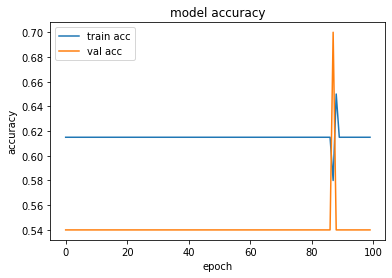

In [65]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

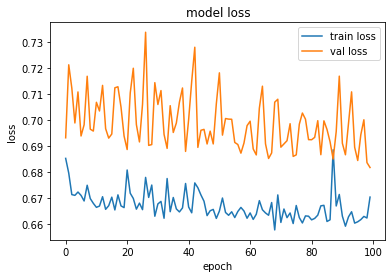

In [66]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [67]:
scores = model.evaluate_generator(training_set,7) 
print("train_accuracy = ", scores[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


train_accuracy =  0.6150000095367432


In [68]:
scores = model.evaluate_generator(test_set,7) 
print("test_accuracy = ", scores[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test_accuracy =  0.5400000214576721


In [69]:
prediction = model.predict_generator(test_set, steps=2 )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [70]:
rounded_prediction = np.argmax(prediction, axis=-1)

In [71]:
true_categories_argmax = np.argmax(y_test, axis = 1)

In [72]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [73]:
cm = confusion_matrix(y_true=true_categories_argmax , y_pred=rounded_prediction)

In [74]:
def plot_confusion_matrix(cm, num_classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(num_classes))
    plt.xticks(tick_marks, num_classes, rotation=45)
    plt.yticks(tick_marks, num_classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [75]:
cm_plot_labels = ['benign', 'malignant']

Confusion matrix, without normalization
[[ 0 23]
 [ 0 27]]


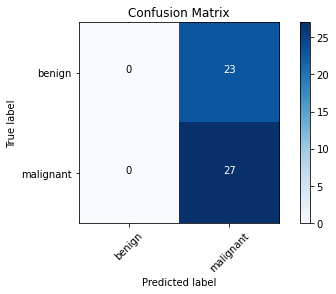

In [76]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [77]:
from sklearn.metrics import classification_report

In [78]:
report = classification_report(true_categories_argmax, rounded_prediction, target_names=cm_plot_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
 print(report)

              precision    recall  f1-score   support

      benign       0.00      0.00      0.00        23
   malignant       0.54      1.00      0.70        27

    accuracy                           0.54        50
   macro avg       0.27      0.50      0.35        50
weighted avg       0.29      0.54      0.38        50



In [80]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________